In [40]:
import pandas as pd
import numpy as np



In [41]:
# Here we have our loading dataset and displaying the headings
df = pd.read_csv('HIV DATABASE WHO.csv', encoding='latin1', header=0)
print(df.head())


    IndicatorCode                                          Indicator  \
0  HIV_0000000027  Reported number of HIV tests performed where r...   
1  HIV_0000000027  Reported number of HIV tests performed where r...   
2  HIV_0000000027  Reported number of HIV tests performed where r...   
3  HIV_0000000027  Reported number of HIV tests performed where r...   
4  HIV_0000000027  Reported number of HIV tests performed where r...   

  ValueType ParentLocationCode         ParentLocation Location type  \
0   numeric                EMR  Eastern Mediterranean       Country   
1   numeric                AFR                 Africa       Country   
2   numeric                EMR  Eastern Mediterranean       Country   
3   numeric                WPR        Western Pacific       Country   
4   numeric                AFR                 Africa       Country   

  SpatialDimValueCode                    Location Period type  Period  ...  \
0                 QAT                       Qatar        Year 

In [42]:
# Drop columns with no values
df_cleaned = df.dropna(axis=1, how='all')


In [43]:
# Basic statistics and column types
display(df_cleaned.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3104 entries, 0 to 3103
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   IndicatorCode           3104 non-null   object 
 1   Indicator               3104 non-null   object 
 2   ValueType               3104 non-null   object 
 3   ParentLocationCode      3104 non-null   object 
 4   ParentLocation          3104 non-null   object 
 5   Location type           3104 non-null   object 
 6   SpatialDimValueCode     3104 non-null   object 
 7   Location                3104 non-null   object 
 8   Period type             3104 non-null   object 
 9   Period                  3104 non-null   int64  
 10  IsLatestYear            3104 non-null   bool   
 11  Dim1 type               3104 non-null   object 
 12  Dim1                    3104 non-null   object 
 13  Dim1ValueCode           3104 non-null   object 
 14  Dim2 type               3104 non-null   

None

In [44]:
# We are going to clean the "Value " column, handling missing values, outliers and non numeric values .
column_ad = 'Value'
if column_ad in df_cleaned.columns:
    # Remove spaces and non-numeric values
    df_cleaned.loc[:, column_ad] = df_cleaned[column_ad].astype(str).str.replace(',', '').str.replace(' ', '')
    df_cleaned.loc[:, column_ad] = pd.to_numeric(df_cleaned[column_ad], errors='coerce')  # Convert to numeric, setting errors to NaN
    
    df_cleaned.loc[:, column_ad] = df_cleaned[column_ad].astype(float)
    display(df_cleaned[column_ad].describe())
    
    display(df_cleaned[column_ad].isnull().sum())  # Showing how many missing values we have
    
else:
    print(f"Column {column_ad} not found. Check column names: {df_cleaned.columns}")


count     1158.0
unique     890.0
top          0.0
freq        14.0
Name: Value, dtype: float64

1946

In [45]:
# Handling missing values

# Drop rows with missing values
df_cleaned = df_cleaned.dropna(subset=[column_ad])



In [46]:
# In this step we need to drop some useless columns
columns_to_drop = [
    'ValueType', 'ParentLocationCode', 'Location type', 'SpatialDimValueCode',
    'Period type', 'Dim1 type', 'Dim1ValueCode', 'Dim2 type','IsLatestYear',
    'Dim2ValueCode', 'FactValueTranslationID', 'DateModified'
]

# Drop no functional clumns
df_cleaned = df_cleaned.drop(columns=[col for col in columns_to_drop if col in df_cleaned.columns])

In [47]:
#To facilitate the process of understanding the database
columns_to_rename = {
    'ParentLocation': 'Continent',
    'Location': 'Country',
    'Period': 'Year',
    'Dim1': 'Sex',
    'Dim2': 'Age'
}

# Rename columns if they exist in the dataset
df_cleaned = df_cleaned.rename(columns={col: new_col for col, new_col in columns_to_rename.items() if col in df_cleaned.columns})


In [48]:
#We will create a key that will help us with the next step 
def concatenate_columns(df):
    df["Concatenated"] = (
        df["Country"].str.replace(" ", "") + 
        df["Year"].astype(str) + 
        df["Sex"].str.replace(" ", "") + 
        df["Age"].str.replace(" ", "")
    )
    return df

# Apply the function
df_cleaned = concatenate_columns(df_cleaned)

# Show the first 6 rows to verify
df_cleaned[["Country", "Year", "Sex", "Age", "Concatenated"]].head(6)



,Country,Year,Sex,Age,Concatenated
0,Qatar,2023,Both sexes,<15 years of age,Qatar2023Bothsexes<15yearsofage
1,Rwanda,2023,Female,15+ years,Rwanda2023Female15+years
2,Iran (Islamic Republic of),2023,Female,15+ years,Iran(IslamicRepublicof)2023Female15+years
3,Malaysia,2023,Male,15+ years,Malaysia2023Male15+years
4,Benin,2023,Both sexes,All age groups (total),Benin2023BothsexesAllagegroups(total)
5,Tajikistan,2023,Both sexes,All age groups (total),Tajikistan2023BothsexesAllagegroups(total)


In [49]:
# Split the dataset based on the "Indicator" column
df_tested = df_cleaned[df_cleaned["Indicator"] == "Reported number of HIV tests performed where results were received by a person (testing volume)"]
df_positive_percentage = df_cleaned[df_cleaned["Indicator"] == "Percentage of HIV-positive results returned to people in the calendar year"]



In [50]:
# Merge the datasets using the "Concatenated" column
df_positive_percentage = df_positive_percentage.merge(
    df_tested[["Concatenated", "Value"]],  # Selecting only needed columns
    on="Concatenated",
    how="left"  # Left join to keep all rows from Positive Percentage
)



In [51]:
# Perform the calculation: (Integer Value * Value) / 100
df_positive_percentage["Positive Cases"] = (df_positive_percentage["Value_x"] * df_positive_percentage["Value_y"]) / 100


In [52]:
#Changing names
df_positive_percentage.rename(columns={"Value_y": "Tested Cases"}, inplace=True)

In [53]:
df_positive_percentage["Negative Cases"] = (df_positive_percentage["Tested Cases"] - df_positive_percentage["Positive Cases"])


In [54]:
print(df_positive_percentage.columns)

Index(['IndicatorCode', 'Indicator', 'Continent', 'Country', 'Year', 'Sex',
       'Age', 'FactValueNumeric', 'Value_x', 'Language', 'Concatenated',
       'Tested Cases', 'Positive Cases', 'Negative Cases'],
      dtype='object')


In [55]:
# Define the thresholds and corresponding labels for categorization
bins = [-float('inf'), 0.3, 1, 3, 10, float('inf')]
labels = ['Very Low Positivity', 'Low Positivity', 'Moderate Positivity', 'Highly Positivity', 'Very High Positivity']

# Create the new column 'current situation' based on 'Value_x'
df_positive_percentage['Current situation'] = pd.cut(df_positive_percentage['Value_x'], bins=bins, labels=labels)

# Show the first few rows to verify the new column
print(df_positive_percentage[['Value_x', 'Current situation']].head())


  Value_x    Current situation
0     0.0  Very Low Positivity
1     0.0  Very Low Positivity
2     0.0  Very Low Positivity
3     0.0  Very Low Positivity
4     0.0  Very Low Positivity


<Figure size 600x300 with 0 Axes>

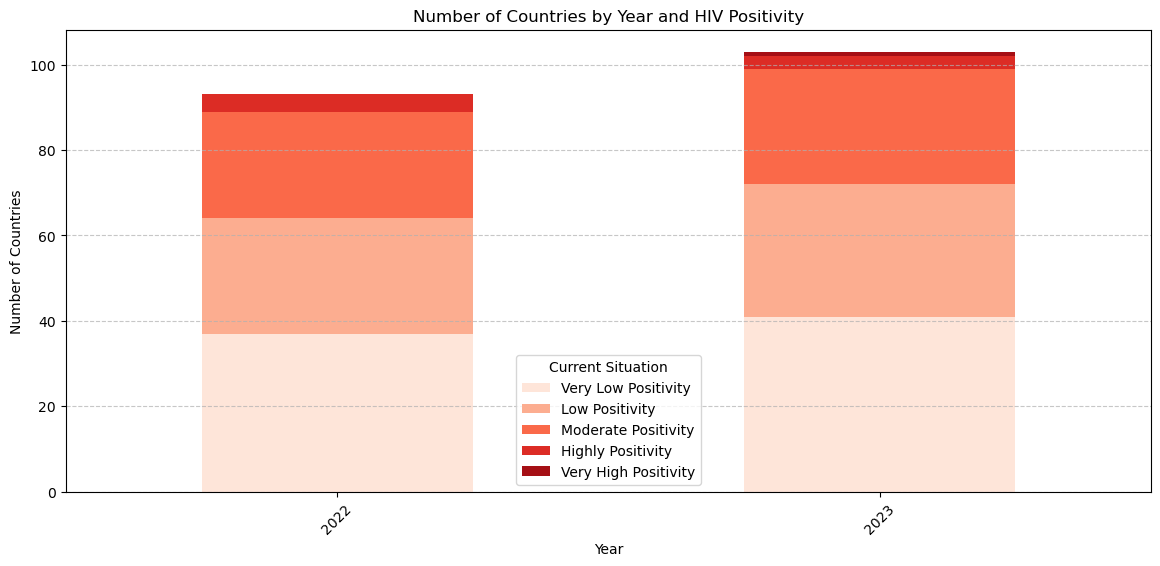

<Figure size 600x300 with 0 Axes>

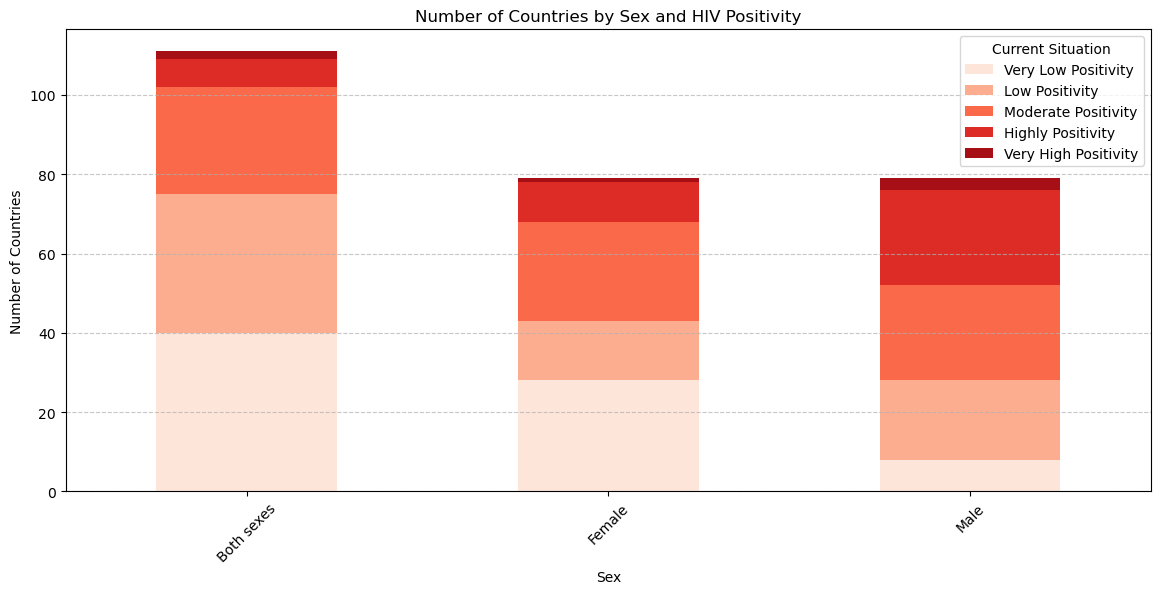

<Figure size 600x300 with 0 Axes>

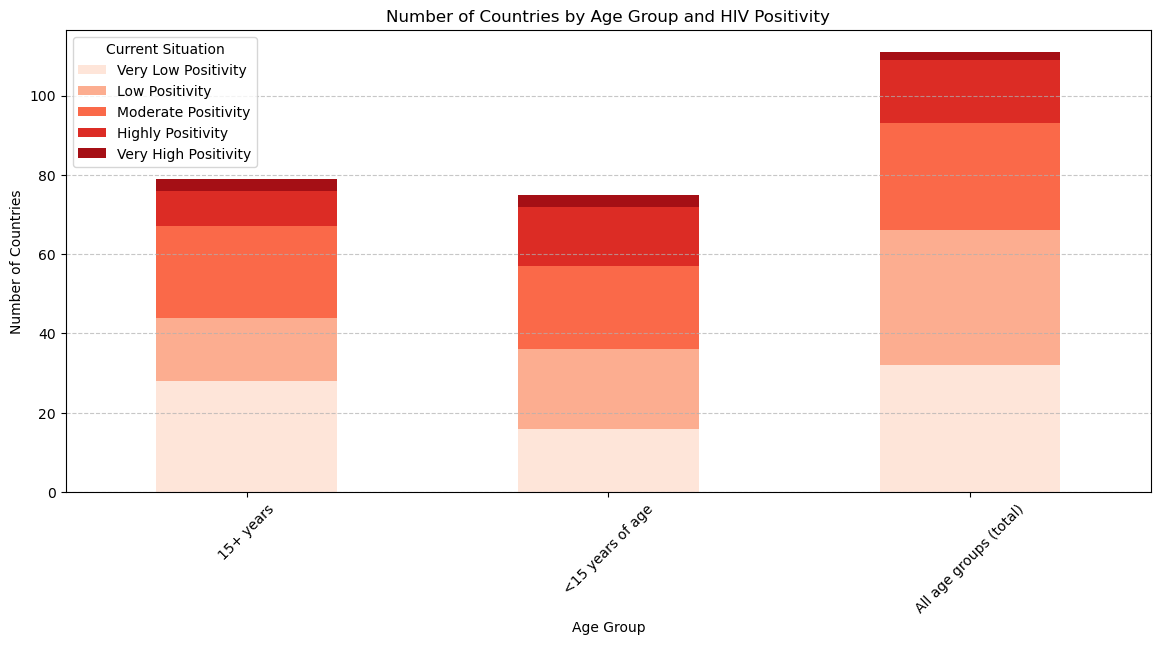

<Figure size 600x300 with 0 Axes>

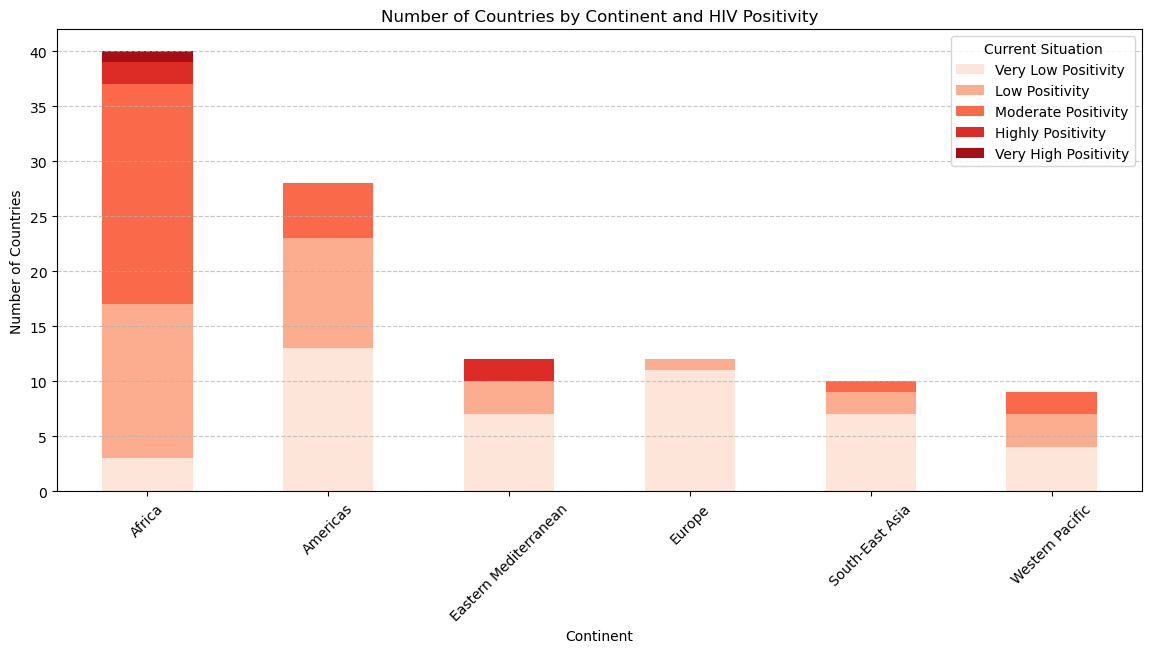

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import numpy as np

# We need to choose only one country per category 
df_unique = df_positive_percentage.drop_duplicates(subset=["Country", "Year", "Sex", "Age", "Current situation"])

# Define a red gradient colormap
red_cmap = LinearSegmentedColormap.from_list("RedGradient", ["#fee5d9", "#fcae91", "#fb6a4a", "#de2d26", "#a50f15"], N=100)

# Function to create bar chart
def create_bar_charts_by_category(category, title, xlabel, ylabel):
    plt.figure(figsize=(6, 3))
    df_filtered = df_positive_percentage.drop_duplicates(subset=["Country", category])
    df_grouped = df_filtered.groupby([category, "Current situation"], observed=False)["Country"].nunique().unstack()

    # Normalize values for gradient mapping
    norm = mcolors.Normalize(vmin=df_grouped.min().min(), vmax=df_grouped.max().max())

    # Apply the custom red gradient colors
    colors = [red_cmap(norm(value)) for value in np.linspace(df_grouped.min().min(), df_grouped.max().max(), df_grouped.shape[1])]

    df_grouped.plot(kind="bar", stacked=True, figsize=(14, 6), color=colors)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(title="Current Situation")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Charts with appropiate titltes
create_bar_charts_by_category("Year", "Number of Countries by Year and HIV Positivity", "Year", "Number of Countries")
create_bar_charts_by_category("Sex", "Number of Countries by Sex and HIV Positivity", "Sex", "Number of Countries")
create_bar_charts_by_category("Age", "Number of Countries by Age Group and HIV Positivity", "Age Group", "Number of Countries")
create_bar_charts_by_category("Continent", "Number of Countries by Continent and HIV Positivity", "Continent", "Number of Countries")


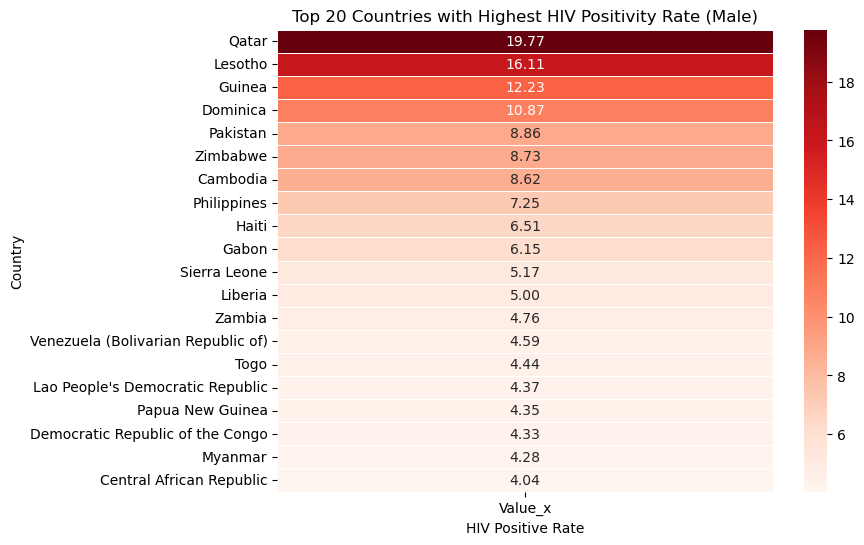

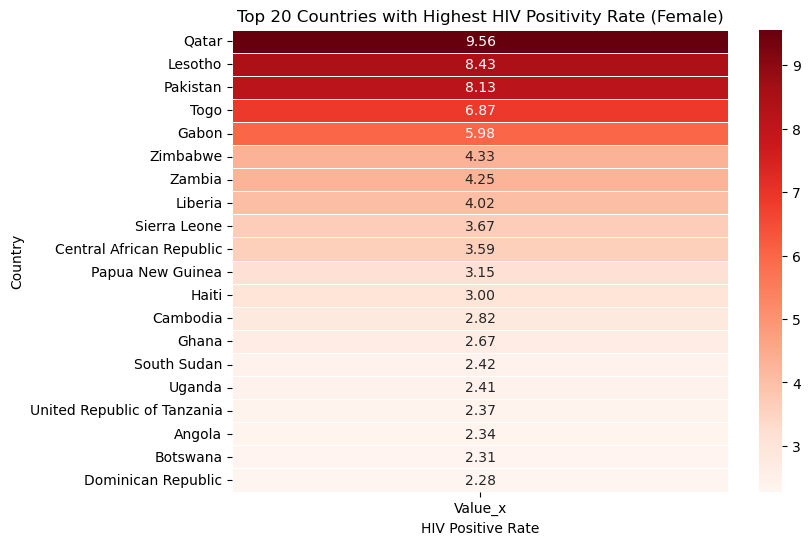

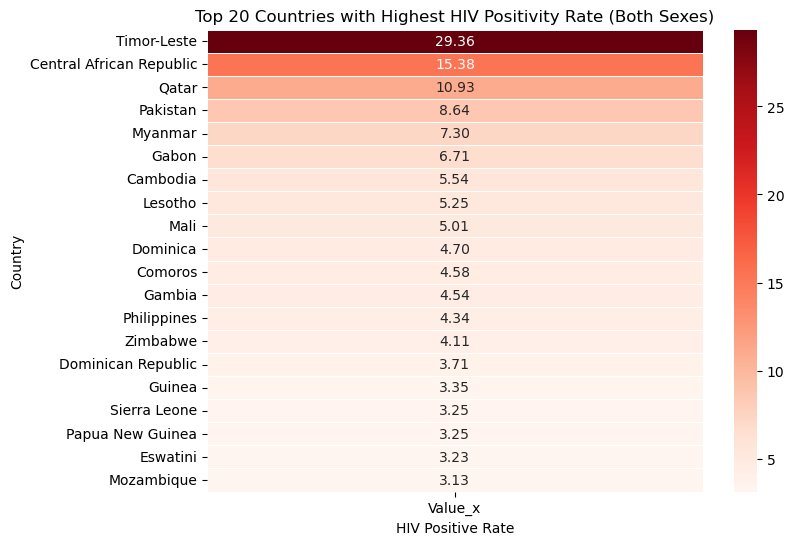

In [57]:
import numpy as np
#Setting all the values as numeric type
df_positive_percentage["Value_x"] = pd.to_numeric(df_positive_percentage["Value_x"], errors="coerce")

# We are going to create a heat map base on each gender 
male_data = df_positive_percentage[df_positive_percentage["Sex"] == "Male"]
female_data = df_positive_percentage[df_positive_percentage["Sex"] == "Female"]
both_sexes_data = df_positive_percentage[df_positive_percentage["Sex"] == "Both sexes"]

# Function to create a heatmap for positivity rate by country
def create_heatmap(data, title):
    # Group by country and calculate the average  positivity rate
    country_positivity = data.groupby("Country")["Value_x"].mean().reset_index()

    # Sort by highest positivity rate and select top 20 countries
    top_countries = country_positivity.sort_values(by="Value_x", ascending=False).head(20)

    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(top_countries.set_index("Country"), annot=True, cmap="Reds", linewidths=0.5, fmt=".2f")
    plt.xlabel("HIV Positive Rate")
    plt.ylabel("Country")
    plt.title(title)
    plt.show()

# Generate heatmaps for each gender category
create_heatmap(male_data, "Top 20 Countries with Highest HIV Positivity Rate (Male)")
create_heatmap(female_data, "Top 20 Countries with Highest HIV Positivity Rate (Female)")
create_heatmap(both_sexes_data, "Top 20 Countries with Highest HIV Positivity Rate (Both Sexes)")

In [58]:
# Here we have our loading Canda Us dataset and took in mind the headers
df_uscanada = pd.read_excel('US_Canada Data.xlsx')
print(df_uscanada.head())

    Indicator  Year Geography Country                 Race/Ethnicity  Gender  \
0  HIV deaths  2022   Alabama     USA  American Indian/Alaska Native  Female   
1  HIV deaths  2022   Alabama     USA  American Indian/Alaska Native  Female   
2  HIV deaths  2022   Alabama     USA  American Indian/Alaska Native  Female   
3  HIV deaths  2022   Alabama     USA  American Indian/Alaska Native  Female   
4  HIV deaths  2022   Alabama     USA  American Indian/Alaska Native  Female   

  Age Group Cases Rate per 100000  
0     13-24     0               0  
1     25-34     0               0  
2     35-44     0               0  
3     45-54     0               0  
4     55-64     0               0  


In [59]:
df_uscanada = df_uscanada[df_uscanada['Year'] <= 2025]

In [60]:
# Replace "0" with "Canada Other" in the Geography column
df_uscanada['Geography'] = df_uscanada['Geography'].replace("0", "Canada Other")

# Drop the 'Cases' column
df_uscanada = df_uscanada.drop(columns=['Cases'])

# Creating groups base on the age
def categorize_age_group(age):
    try:
        age = age.strip()  # Remove any leading/trailing spaces
        if '-' in age:
            start, end = map(int, age.split('-'))
            if end <= 24:
                return 'Young'
            elif end <= 54:
                return 'Middle-aged'
            else:
                return 'Older'
        elif age.isdigit():
            return 'Older' if int(age) >= 55 else 'Young'
        else:
            return 'Unknown'  # Handle unexpected values
    except:
        return 'Unknown'

# Apply categorization
df_uscanada['Age Group'] = df_uscanada['Age Group'].apply(categorize_age_group)


df_uscanada.loc[df_uscanada['Age Group'] == 'Unknown', 'Age Group'] = 'No Specified Age'
#Showing the first ten records
df_uscanada.head(10)





,Indicator,Year,Geography,Country,Race/Ethnicity,Gender,Age Group,Rate per 100000
0,HIV deaths,2022,Alabama,USA,American Indian/Alaska Native,Female,Young,0
1,HIV deaths,2022,Alabama,USA,American Indian/Alaska Native,Female,Middle-aged,0
2,HIV deaths,2022,Alabama,USA,American Indian/Alaska Native,Female,Middle-aged,0
3,HIV deaths,2022,Alabama,USA,American Indian/Alaska Native,Female,Middle-aged,0
4,HIV deaths,2022,Alabama,USA,American Indian/Alaska Native,Female,Older,0
5,HIV deaths,2022,Alabama,USA,American Indian/Alaska Native,Female,No Specified Age,0
6,HIV deaths,2022,Alabama,USA,American Indian/Alaska Native,Male,Young,0
7,HIV deaths,2022,Alabama,USA,American Indian/Alaska Native,Male,Middle-aged,0
8,HIV deaths,2022,Alabama,USA,American Indian/Alaska Native,Male,Middle-aged,0
9,HIV deaths,2022,Alabama,USA,American Indian/Alaska Native,Male,Middle-aged,0


In [61]:
# Convert 'Rate per 100000' to numeric
df_uscanada['Rate per 100000'] = pd.to_numeric(df_uscanada['Rate per 100000'], errors='coerce')

# Drop rows where 'Rate per 100000' is 0 or NA (non-numeric values)
df_uscanada = df_uscanada[df_uscanada['Rate per 100000'] > 0]



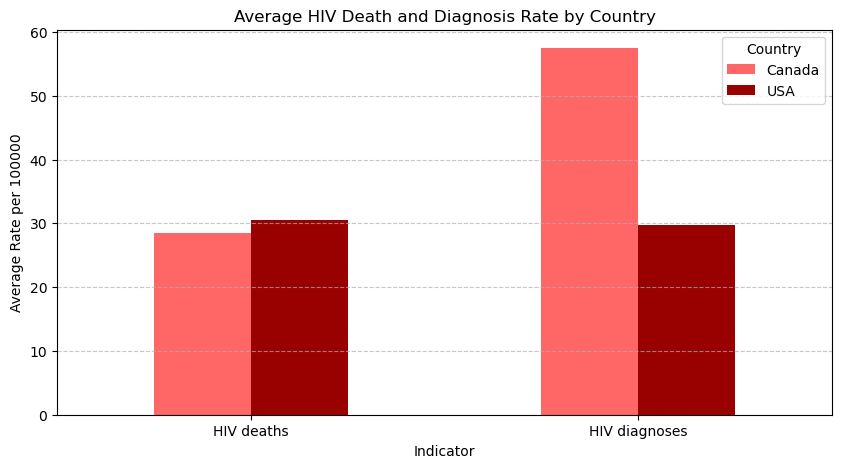

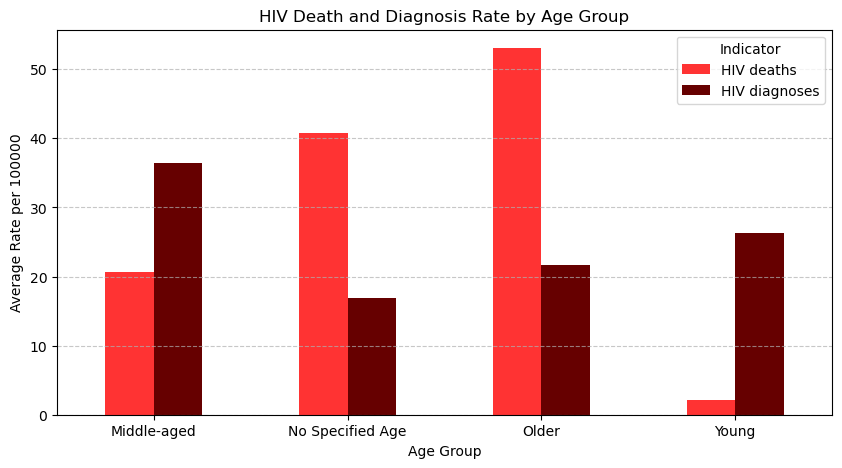

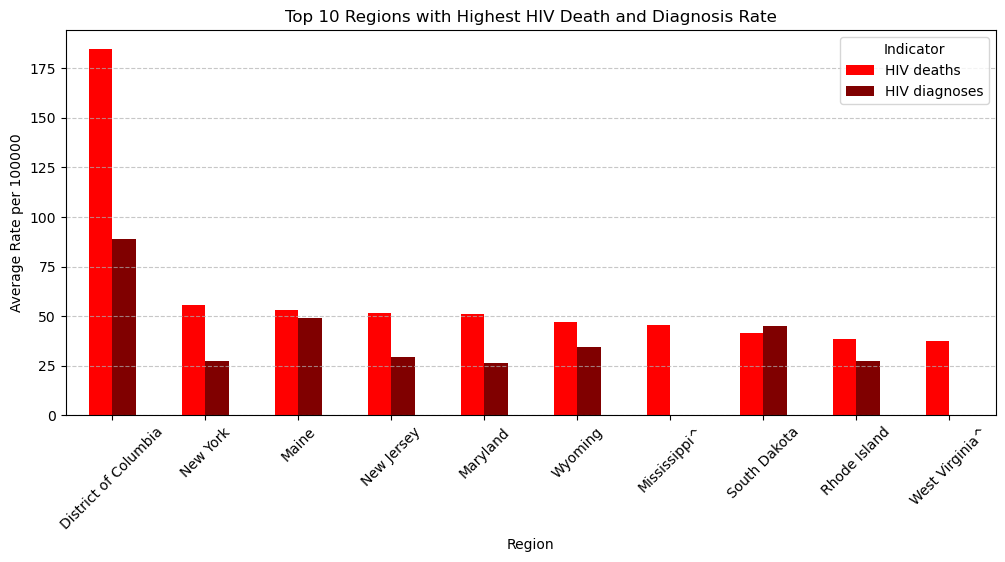

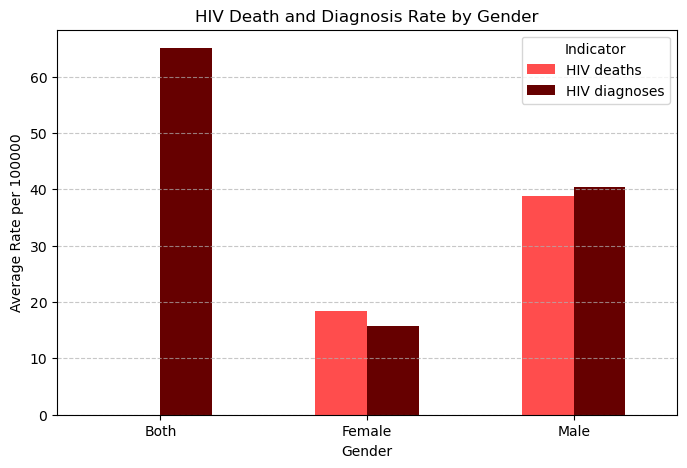

In [62]:
# Creayting Visualizations base on different categories


# Visualization 1: Average Rate per Indicator and Country
avg_rate_indicator_country = df_uscanada.groupby(['Indicator', 'Country'])['Rate per 100000'].mean().unstack()
avg_rate_indicator_country.plot(kind='bar', figsize=(10, 5), color=['#ff6666', '#990000'])
plt.xlabel('Indicator')
plt.ylabel('Average Rate per 100000')
plt.title('Average HIV Death and Diagnosis Rate by Country')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 2: Breakdown by Age Group and Indicator
age_group_avg_rate_indicator = df_uscanada.groupby(['Age Group', 'Indicator'])['Rate per 100000'].mean().unstack()
age_group_avg_rate_indicator.plot(kind='bar', figsize=(10, 5), color=['#ff3333', '#660000'])
plt.xlabel('Age Group')
plt.ylabel('Average Rate per 100000')
plt.title('HIV Death and Diagnosis Rate by Age Group')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 3: Top 10 Regions with Highest Rates by Indicator
top_regions_by_indicator = df_uscanada.groupby(['Geography', 'Indicator'])['Rate per 100000'].mean().unstack().nlargest(10, 'HIV deaths')
top_regions_by_indicator.plot(kind='bar', figsize=(12, 5), color=['#ff0000', '#800000'])
plt.xlabel('Region')
plt.ylabel('Average Rate per 100000')
plt.title('Top 10 Regions with Highest HIV Death and Diagnosis Rate')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 4: Gender Comparison by Indicator
gender_avg_rate_indicator = df_uscanada.groupby(['Gender', 'Indicator'])['Rate per 100000'].mean().unstack()
gender_avg_rate_indicator.plot(kind='bar', figsize=(8, 5), color=['#ff4d4d', '#660000'])
plt.xlabel('Gender')
plt.ylabel('Average Rate per 100000')
plt.title('HIV Death and Diagnosis Rate by Gender')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


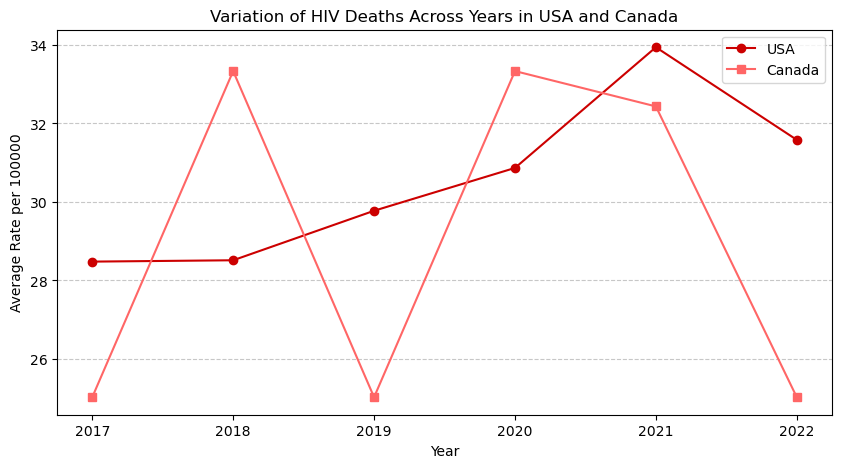

In [63]:
# Filter data for USA and Canada for HIV deaths
usa_hiv_deaths = df_uscanada[(df_uscanada['Country'] == 'USA') & (df_uscanada['Indicator'] == 'HIV deaths')]
canada_hiv_deaths = df_uscanada[(df_uscanada['Country'] == 'Canada') & (df_uscanada['Indicator'] == 'HIV deaths')]

# Group by year and calculate the average rate per 100,000
usa_hiv_deaths_yearly = usa_hiv_deaths.groupby('Year')['Rate per 100000'].mean()
canada_hiv_deaths_yearly = canada_hiv_deaths.groupby('Year')['Rate per 100000'].mean()

# Plot the trend of HIV deaths across years for both USA and Canada using a red palette
plt.figure(figsize=(10, 5))
plt.plot(usa_hiv_deaths_yearly.index, usa_hiv_deaths_yearly.values, marker='o', linestyle='-', color='#cc0000', label='USA')  # Dark Red
plt.plot(canada_hiv_deaths_yearly.index, canada_hiv_deaths_yearly.values, marker='s', linestyle='-', color='#ff6666', label='Canada')  # Light Red

plt.xlabel('Year')
plt.ylabel('Average Rate per 100000')
plt.title('Variation of HIV Deaths Across Years in USA and Canada')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


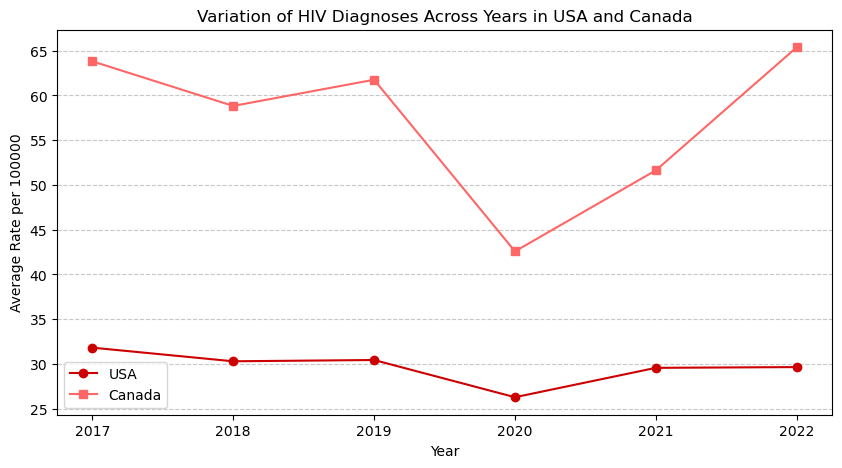

In [64]:
# Filter data for USA and Canada for HIV diagnoses
usa_hiv_diagnoses = df_uscanada[(df_uscanada['Country'] == 'USA') & (df_uscanada['Indicator'] == 'HIV diagnoses')]
canada_hiv_diagnoses = df_uscanada[(df_uscanada['Country'] == 'Canada') & (df_uscanada['Indicator'] == 'HIV diagnoses')]

# Group by year and calculate the average rate per 100,000
usa_hiv_diagnoses_yearly = usa_hiv_diagnoses.groupby('Year')['Rate per 100000'].mean()
canada_hiv_diagnoses_yearly = canada_hiv_diagnoses.groupby('Year')['Rate per 100000'].mean()

# Plot the trend of HIV diagnoses across years for both USA and Canada using a red palette
plt.figure(figsize=(10, 5))
plt.plot(usa_hiv_diagnoses_yearly.index, usa_hiv_diagnoses_yearly.values, marker='o', linestyle='-', color='#cc0000', label='USA')  # Dark Red
plt.plot(canada_hiv_diagnoses_yearly.index, canada_hiv_diagnoses_yearly.values, marker='s', linestyle='-', color='#ff6666', label='Canada')  # Light Red

plt.xlabel('Year')
plt.ylabel('Average Rate per 100000')
plt.title('Variation of HIV Diagnoses Across Years in USA and Canada')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


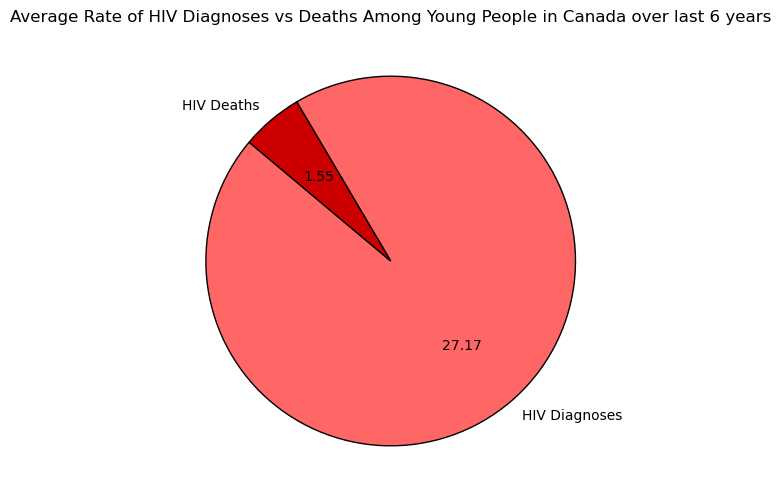

In [65]:
#Define young people in Canada base on age group
canada_young = df_uscanada[(df_uscanada['Country'] == 'Canada') & (df_uscanada['Age Group'] == 'Young')]

#Declaring diagnoses and deaths
average_rate_canada_young_diagnoses = canada_young[canada_young['Indicator'] == 'HIV diagnoses']['Rate per 100000'].mean()
average_rate_canada_young_deaths = canada_young[canada_young['Indicator'] == 'HIV deaths']['Rate per 100000'].mean()


# Create a pie chart for the average rate of HIV diagnoses and deaths among young people in Canada
labels = ['HIV Diagnoses', 'HIV Deaths']
values = [average_rate_canada_young_diagnoses, average_rate_canada_young_deaths]
colors = ['#ff6666', '#cc0000']  # Light red for diagnoses, dark red for deaths

#Display the pie chart 
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct=lambda p: f'{p * sum(values) / 100:.2f}', 
        colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title('Average Rate of HIV Diagnoses vs Deaths Among Young People in Canada over last 6 years')
plt.show()


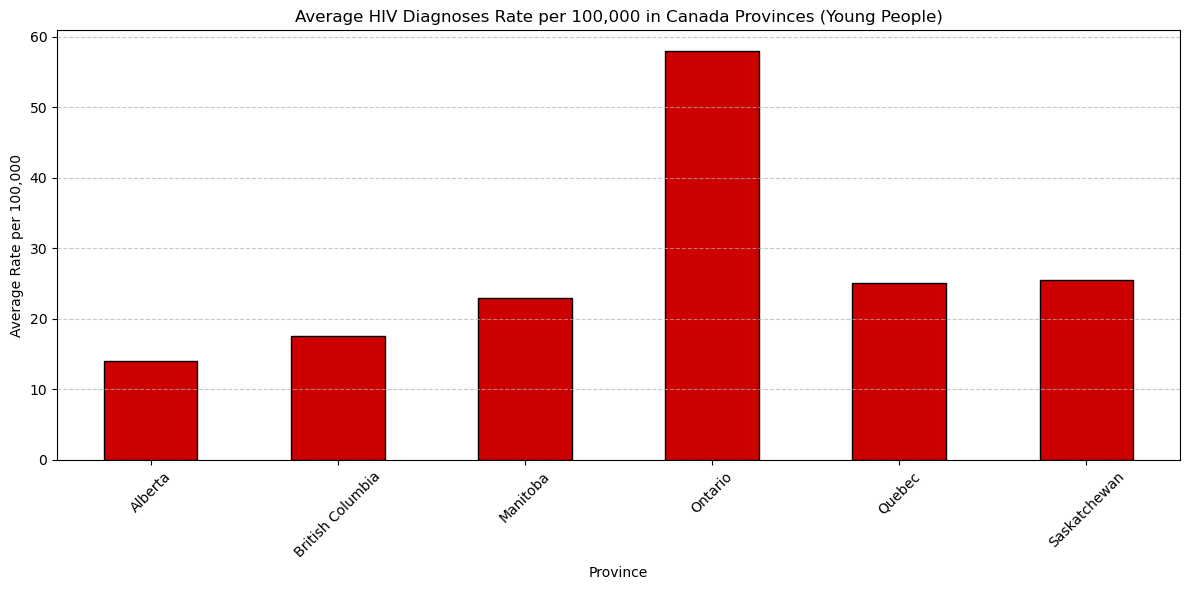

In [66]:

# Filter for Canada, HIV diagnoses, and Young age group
canada_young_diagnoses = df_uscanada[(df_uscanada['Country'] == 'Canada') & 
                                     (df_uscanada['Indicator'] == 'HIV diagnoses') & 
                                     (df_uscanada['Age Group'] == 'Young')]

# Group by province and calculate the average rate per 100,000
canada_province_avg_rate = canada_young_diagnoses.groupby('Geography')['Rate per 100000'].mean()

# Create the bar chart
plt.figure(figsize=(12, 6))
canada_province_avg_rate.plot(kind='bar', color='#cc0000', edgecolor='black')

plt.xlabel('Province')
plt.ylabel('Average Rate per 100,000')
plt.title('Average HIV Diagnoses Rate per 100,000 in Canada Provinces (Young People)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


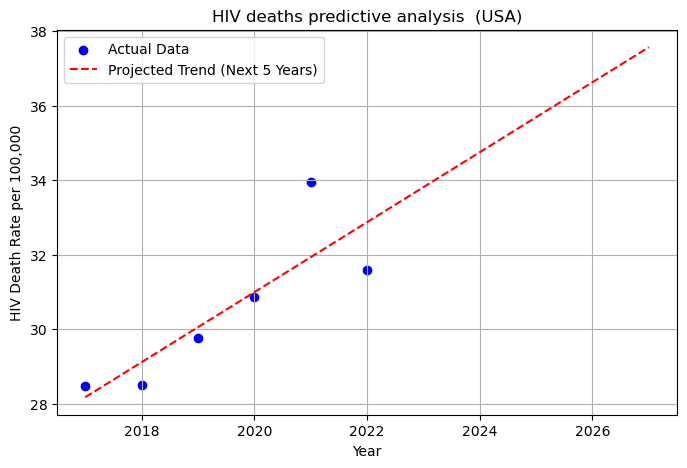

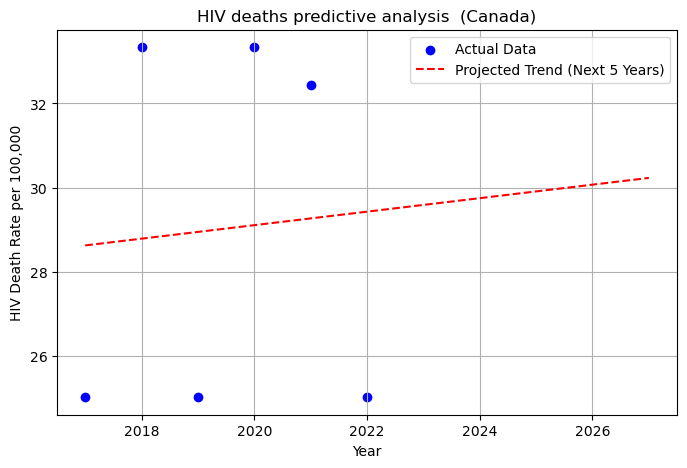

((0.9394737268751083, -1866.740973142245, 0.7120099199031726),
 (0.1602380952380955, -294.57166666666717, 0.004644757510519737))

In [67]:
from sklearn.linear_model import LinearRegression

# Initially we filter the Indicator column to focus only in HIV deaths
df_hiv_deaths = df_uscanada[df_uscanada["Indicator"] == "HIV deaths"]

# Now we split the data for both countries
usa_hiv_deaths = df_hiv_deaths[df_hiv_deaths["Country"] == "USA"]
canada_hiv_deaths = df_hiv_deaths[df_hiv_deaths["Country"] == "Canada"]

# Now we focus on our to variables of interest, year as indedependent  variable and Rate per 100000 as dependent variable
usa_hiv_deaths_yearly = usa_hiv_deaths.groupby("Year")["Rate per 100000"].mean().reset_index()
canada_hiv_deaths_yearly = canada_hiv_deaths.groupby("Year")["Rate per 100000"].mean().reset_index()

# Now we are going to perform the regression analysis and show the results in a simple linear trend plot
def perform_regression_with_future(df, country):
    X = df["Year"].values.reshape(-1, 1)  # Independent variable (Year)
    y = df["Rate per 100000"].values  # Dependent variable (HIV Death Rate)

    model = LinearRegression()
    model.fit(X, y)

    #We need to predict the next 5 years base on our actual data 
    future_years = np.arange(X.min(), X.max() + 6).reshape(-1, 1)  # Extend 5 more years
    y_pred_future = model.predict(future_years)

    # Plot actual data and predictions
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, color="blue", label="Actual Data")
    plt.plot(future_years, y_pred_future, color="red", linestyle="--", label="Projected Trend (Next 5 Years)")
    plt.xlabel("Year")
    plt.ylabel("HIV Death Rate per 100,000")
    plt.title(f"HIV deaths predictive analysis  ({country})")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model.coef_[0], model.intercept_, model.score(X, y)

# Regression for USA with future projections
slope_usa_future, intercept_usa_future, r2_usa_future = perform_regression_with_future(usa_hiv_deaths_yearly, "USA")

# Regression for Canada with future projections
slope_canada_future, intercept_canada_future, r2_canada_future = perform_regression_with_future(canada_hiv_deaths_yearly, "Canada")

# Display results
(slope_usa_future, intercept_usa_future, r2_usa_future), (slope_canada_future, intercept_canada_future, r2_canada_future)


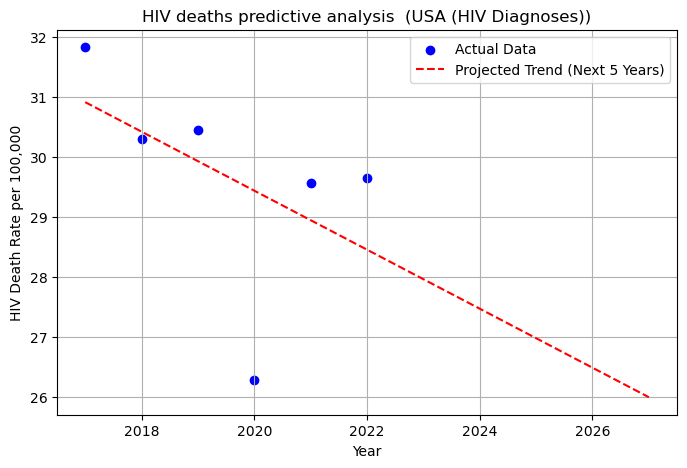

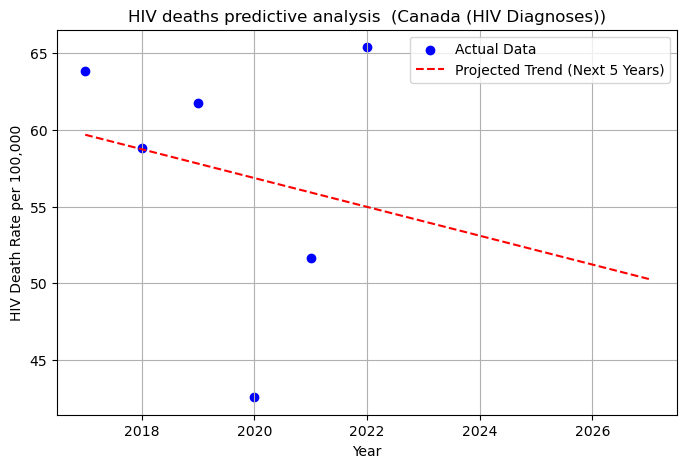

((-0.49161064525404274, 1022.4891847152721, 0.24742674121966113),
 (-0.9398680969665549, 1955.3952240875187, 0.04082779494355826))

In [68]:
# Initially we filter the Indicator column to focus only in HIV diagnoses
df_hiv_diagnoses = df_uscanada[df_uscanada["Indicator"] == "HIV diagnoses"]

# Now we split the data for both countries
usa_hiv_diagnoses = df_hiv_diagnoses[df_hiv_diagnoses["Country"] == "USA"]
canada_hiv_diagnoses = df_hiv_diagnoses[df_hiv_diagnoses["Country"] == "Canada"]

# Group by year and calculate the mean rate per 100,000
usa_hiv_diagnoses_yearly = usa_hiv_diagnoses.groupby("Year")["Rate per 100000"].mean().reset_index()
canada_hiv_diagnoses_yearly = canada_hiv_diagnoses.groupby("Year")["Rate per 100000"].mean().reset_index()

# Perform regression and plot future predictions for HIV Diagnoses in the USA
slope_usa_diagnoses, intercept_usa_diagnoses, r2_usa_diagnoses = perform_regression_with_future(usa_hiv_diagnoses_yearly, "USA (HIV Diagnoses)")

# Perform regression and plot future predictions for HIV Diagnoses in Canada
slope_canada_diagnoses, intercept_canada_diagnoses, r2_canada_diagnoses = perform_regression_with_future(canada_hiv_diagnoses_yearly, "Canada (HIV Diagnoses)")

# Display results
(slope_usa_diagnoses, intercept_usa_diagnoses, r2_usa_diagnoses), (slope_canada_diagnoses, intercept_canada_diagnoses, r2_canada_diagnoses)


In [69]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

# Define the features and target
selected_features = ["Year", "Age Group", "Race/Ethnicity", "Gender"]
target = "Rate per 100000"

# Function to perform multivariable regression including Year
def perform_combined_multivariable_regression_with_year(df, category):
    # Separate features and target variable
    X = df[selected_features]
    y = df[target]

    # One-hot encoding for categorical variables (Age Group, Race/Ethnicity, Gender)
    categorical_features = ["Age Group", "Race/Ethnicity", "Gender"]
    preprocessor = ColumnTransformer(transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ], remainder="passthrough")

    # Create regression model pipeline
    model = make_pipeline(preprocessor, LinearRegression())

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate R² score
    r2 = r2_score(y_test, y_pred)

    print(f"Multivariable Regression R² Score for {category}: {r2:.4f}")

    return r2

# Perform regression for HIV deaths (Both Countries Combined) with Year
r2_hiv_deaths_combined_year = perform_combined_multivariable_regression_with_year(df_hiv_deaths, "HIV Deaths")

# Perform regression for HIV diagnoses (Both Countries Combined) with Year
r2_hiv_diagnoses_combined_year = perform_combined_multivariable_regression_with_year(df_hiv_diagnoses, "HIV Diagnoses")

# Return updated R² scores for reference
r2_hiv_deaths_combined_year, r2_hiv_diagnoses_combined_year



Multivariable Regression R² Score for HIV Deaths: 0.2115
Multivariable Regression R² Score for HIV Diagnoses: 0.2991


(0.2115024813394527, 0.2991419651065186)

In [73]:
#March 13 updates Final Project
import pandas as pd
# Here we have our summary dataset of Canada Usa and some african countries
df_final = pd.read_excel('HIV Data Final Presentation.xlsx')
print(df_final.head())
# Verify if all missing values are resolved
missing_values_after_fix = df_final['Cases'].isnull().sum()

# Display the number of missing values left
missing_values_after_fix
# Calculate the total sum of the 'Cases' column
total_cases_sum = df_final['Cases'].sum()

# Display the total sum
total_cases_sum



    Indicator  Year Geography Country          Race/Ethnicity  Gender  \
0  HIV deaths  2022   Alabama     USA  Black/African American  Female   
1  HIV deaths  2022   Alabama     USA  Black/African American  Female   
2  HIV deaths  2022   Alabama     USA  Black/African American  Female   
3  HIV deaths  2022   Alabama     USA  Black/African American  Female   
4  HIV deaths  2022   Alabama     USA  Black/African American  Female   

  Age Group  Cases  
0     15-49    1.0  
1     15-49    4.0  
2     15-49    8.0  
3     15-49    6.0  
4       50+   20.0  


7408836.0

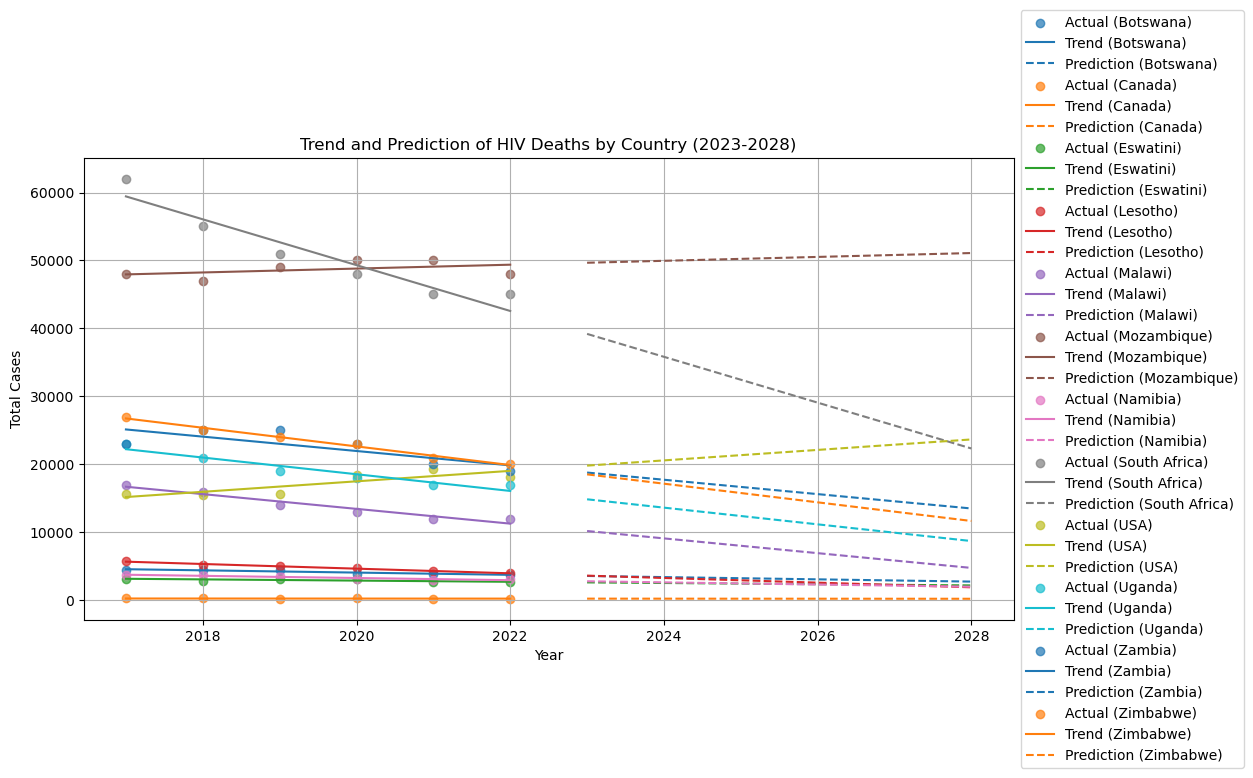

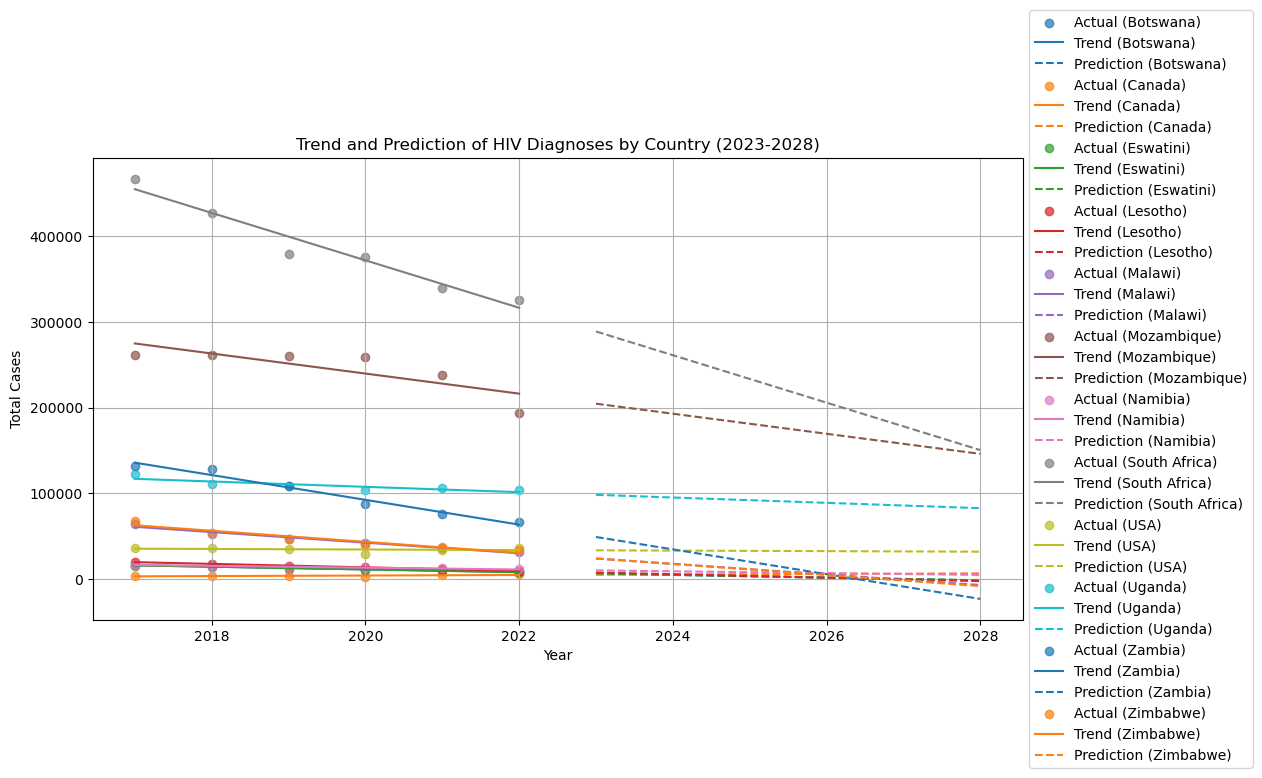

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert 'Year' and 'Cases' to numeric
df_final['Year'] = pd.to_numeric(df_final['Year'], errors='coerce')
df_final['Cases'] = pd.to_numeric(df_final['Cases'], errors='coerce')

# Standardize indicator names to match dataset formatting
df_final['Indicator'] = df_final['Indicator'].str.lower()

# Filter data for HIV deaths and diagnoses
df_deaths = df_final[df_final['Indicator'] == 'hiv deaths']
df_diagnoses = df_final[df_final['Indicator'] == 'hiv diagnoses']

# Sum cases per year for each country
df_deaths_sum = df_deaths.groupby(['Year', 'Country'])['Cases'].sum().reset_index()
df_diagnoses_sum = df_diagnoses.groupby(['Year', 'Country'])['Cases'].sum().reset_index()

# Define function to plot trends with predictions for 2023-2028
def plot_trend_with_prediction(df_grouped, title):
    plt.figure(figsize=(12, 6))

    # Extract unique countries
    countries = df_grouped['Country'].unique()
    
    for country in countries:
        country_data = df_grouped[df_grouped['Country'] == country]

        X = country_data['Year'].values.reshape(-1, 1)
        y = country_data['Cases'].values

        if len(X) > 1:  # Ensure there's enough data for modeling
            # Fit linear regression model
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)

            # Predict for future years (2023-2028)
            future_years = np.array(range(2023, 2029)).reshape(-1, 1)
            future_pred = model.predict(future_years)
            
            # Plot actual points
            plt.scatter(X, y, label=f'Actual ({country})', alpha=0.7)

            # Plot trend as a solid continuous line and store its color
            trend_line, = plt.plot(X, y_pred, linestyle='-', label=f'Trend ({country})')

            # Use the same color for the prediction line to maintain continuity
            plt.plot(future_years, future_pred, linestyle='--', color=trend_line.get_color(), label=f'Prediction ({country})')

    plt.xlabel('Year')
    plt.ylabel('Total Cases')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

# Generate trend charts with predictions for all countries
plot_trend_with_prediction(df_deaths_sum, "Trend and Prediction of HIV Deaths by Country (2023-2028)")
plot_trend_with_prediction(df_diagnoses_sum, "Trend and Prediction of HIV Diagnoses by Country (2023-2028)")


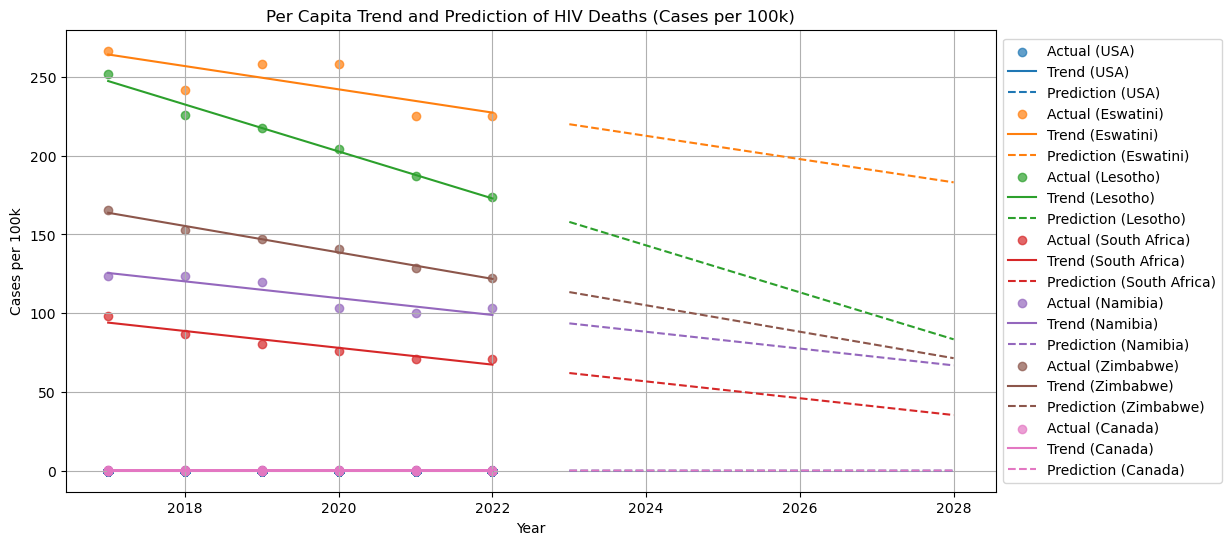

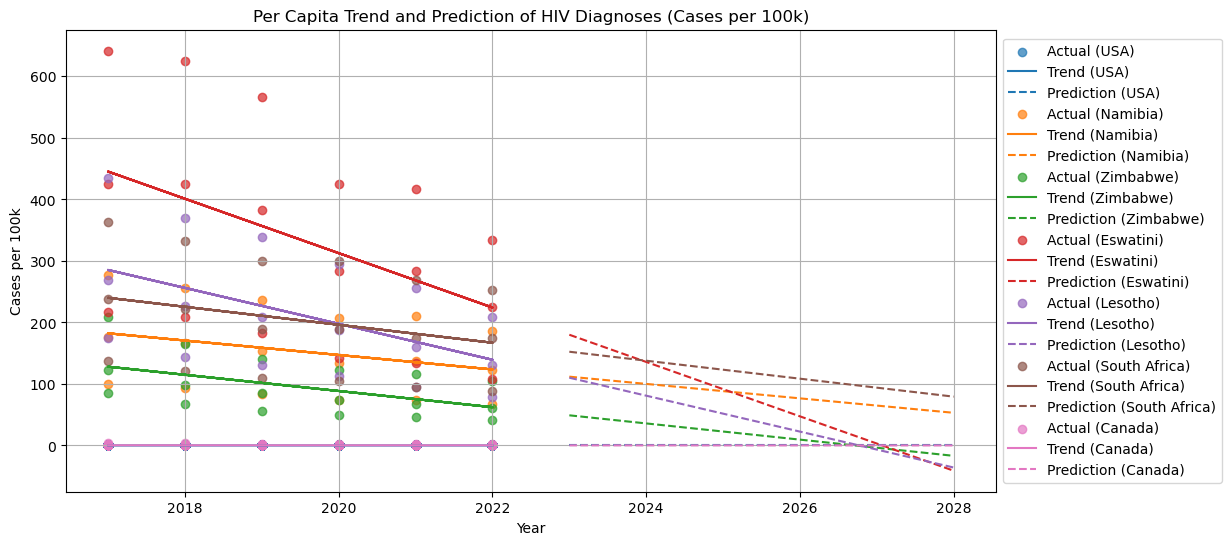

In [123]:

# Define population values (in millions) for selected countries
population_dict = {
    "Canada": 40,
    "USA": 340,
    "Eswatini": 1.2,
    "Lesotho": 2.3,
    "South Africa": 63.2,
    "Namibia": 3,
    "Zimbabwe": 16.34
}

# List of selected countries
selected_countries = ["Canada", "USA", "Eswatini", "Lesotho", "South Africa", "Namibia", "Zimbabwe"]

# Filter dataset to include only selected countries
df_final = df_final[df_final["Country"].isin(selected_countries)].copy()

# Ensure 'Indicator' column is in lowercase for consistency
df_final['Indicator'] = df_final['Indicator'].str.lower()

# Filter data for HIV deaths and diagnoses
df_selected_deaths = df_final[df_final['Indicator'] == 'hiv deaths'].copy()
df_selected_diagnoses = df_final[df_final['Indicator'] == 'hiv diagnoses'].copy()

df_selected_deaths["Cases_per_100k"] = df_selected_deaths.apply(
    lambda row: (row["Cases"] / (population_dict.get(row["Country"], np.nan) * 1_000_000)) * 100_000, axis=1
)

df_selected_diagnoses["Cases_per_100k"] = df_selected_diagnoses.apply(
    lambda row: (row["Cases"] / (population_dict.get(row["Country"], np.nan) * 1_000_000)) * 100_000, axis=1
)



# Drop rows where 'Cases_per_million' is still NaN (to avoid issues in modeling)
df_selected_deaths = df_selected_deaths.dropna(subset=["Cases_per_100k"])
df_selected_diagnoses = df_selected_diagnoses.dropna(subset=["Cases_per_100k"])

# Function to plot per capita trends with predictions for 2023-2028
def plot_per_capita_trend(df_grouped, title):
    plt.figure(figsize=(12, 6))

    # Extract unique countries
    countries = df_grouped['Country'].unique()
    
    for country in countries:
        country_data = df_grouped[df_grouped['Country'] == country]

        X = country_data['Year'].values.reshape(-1, 1)
        y = country_data['Cases_per_100k'].values

        if len(X) > 1:  # Ensure there's enough data for modeling
            # Fit linear regression model
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)

            # Predict for future years (2023-2028)
            future_years = np.array(range(2023, 2029)).reshape(-1, 1)
            future_pred = model.predict(future_years)

            # Plot actual points
            plt.scatter(X, y, label=f'Actual ({country})', alpha=0.7)

            # Plot trend and store its color
            trend_line, = plt.plot(X, y_pred, linestyle='-', label=f'Trend ({country})')

            # Use the same color for the prediction line
            plt.plot(future_years, future_pred, linestyle='--', color=trend_line.get_color(), label=f'Prediction ({country})')

    plt.xlabel('Year')
    plt.ylabel('Cases per 100k')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

# Plot per capita trends with predictions for selected countries
plot_per_capita_trend(df_selected_deaths, "Per Capita Trend and Prediction of HIV Deaths (Cases per 100k)")
plot_per_capita_trend(df_selected_diagnoses, "Per Capita Trend and Prediction of HIV Diagnoses (Cases per 100k)")


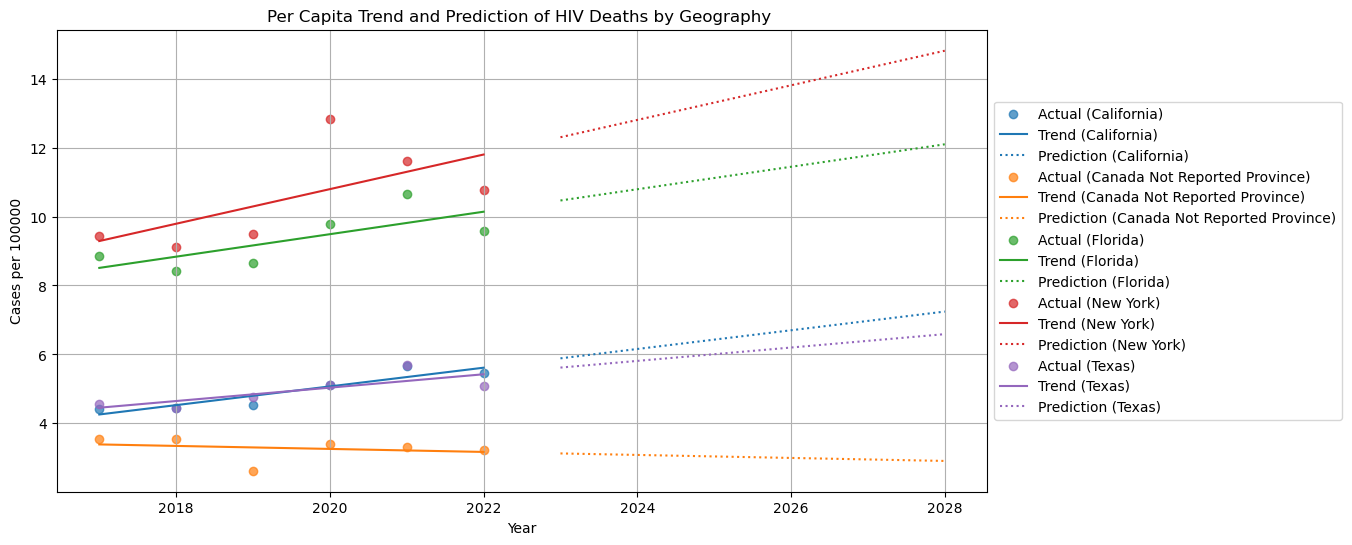

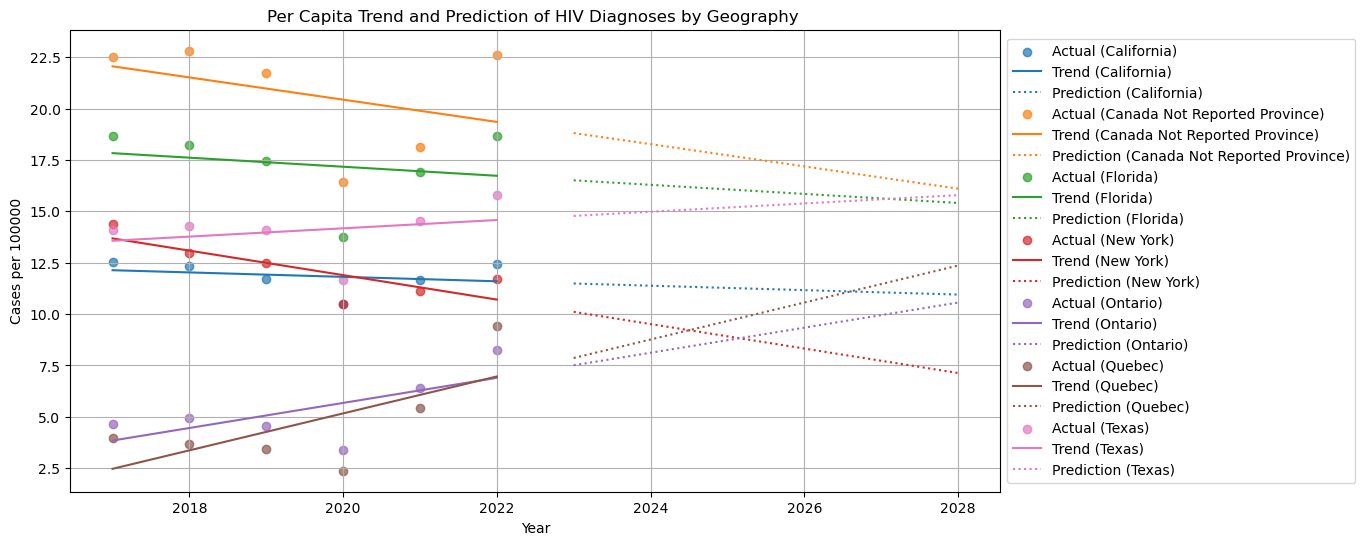

In [133]:
# Aggregate total cases per geography, year, and indicator for USA and Canada
df_geography_indicator_cases = df_final.groupby(['Year', 'Geography', 'Country', 'Indicator'])['Cases'].sum().reset_index()
# Define selected geographies and their population sizes (in millions)
selected_geographies = {
    "Ontario": 15,
    "Quebec": 9,
    "Florida": 23,
    "New York": 19,
    "California": 39,
    "Texas": 31,
    "Canada Not Reported Province": 8
}

# Filter dataset for selected geographies and create copies to avoid warnings
df_selected_geography_deaths = df_geography_indicator_cases[
    (df_geography_indicator_cases['Geography'].isin(selected_geographies.keys())) & 
    (df_geography_indicator_cases['Indicator'] == 'hiv deaths')
].copy()

df_selected_geography_diagnoses = df_geography_indicator_cases[
    (df_geography_indicator_cases['Geography'].isin(selected_geographies.keys())) & 
    (df_geography_indicator_cases['Indicator'] == 'hiv diagnoses')
].copy()

# Normalize HIV deaths per 1000 for selected geographies
df_selected_geography_deaths["Cases_per_100000"] = df_selected_geography_deaths.apply(
    lambda row: (row["Cases"] / (selected_geographies.get(row["Geography"], np.nan) * 1_000_000)) * 100000, axis=1
)

# Normalize HIV diagnoses per 1000 for selected geographies
df_selected_geography_diagnoses["Cases_per_100000"] = df_selected_geography_diagnoses.apply(
    lambda row: (row["Cases"] / (selected_geographies.get(row["Geography"], np.nan) * 1_000_000)) * 100000, axis=1
)


# Function to plot per capita trends with predictions for selected geographies
def plot_per_capita_trend_geography(df_grouped, title):
    plt.figure(figsize=(12, 6))

    # Extract unique geographies
    geographies = df_grouped['Geography'].unique()
    
    for geography in geographies:
        geo_data = df_grouped[df_grouped['Geography'] == geography]

        X = geo_data['Year'].values.reshape(-1, 1)
        y = geo_data['Cases_per_100000'].values

        if len(X) > 1:  # Ensure there's enough data for modeling
            # Fit linear regression model
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)

            # Predict for future years (2023-2028)
            future_years = np.array(range(2023, 2029)).reshape(-1, 1)
            future_pred = model.predict(future_years)

            # Plot actual points
            plt.scatter(X, y, label=f'Actual ({geography})', alpha=0.7)

            # Plot trend and store its color
            trend_line, = plt.plot(X, y_pred, linestyle='-', label=f'Trend ({geography})')

            # Use the same color for the prediction line
            plt.plot(future_years, future_pred, linestyle='dotted', color=trend_line.get_color(), label=f'Prediction ({geography})')

    plt.xlabel('Year')
    plt.ylabel('Cases per 100000')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

# Plot per capita trends with predictions for selected geographies
plot_per_capita_trend_geography(df_selected_geography_deaths, "Per Capita Trend and Prediction of HIV Deaths by Geography ")
plot_per_capita_trend_geography(df_selected_geography_diagnoses, "Per Capita Trend and Prediction of HIV Diagnoses by Geography ")



23:38:23 - cmdstanpy - INFO - Chain [1] start processing
23:38:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jabui\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
23:38:23 - cmdstanpy - INFO - Chain [1] start processing
23:38:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jabui\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
23:38:24 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jabui\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
23:38:24 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanp

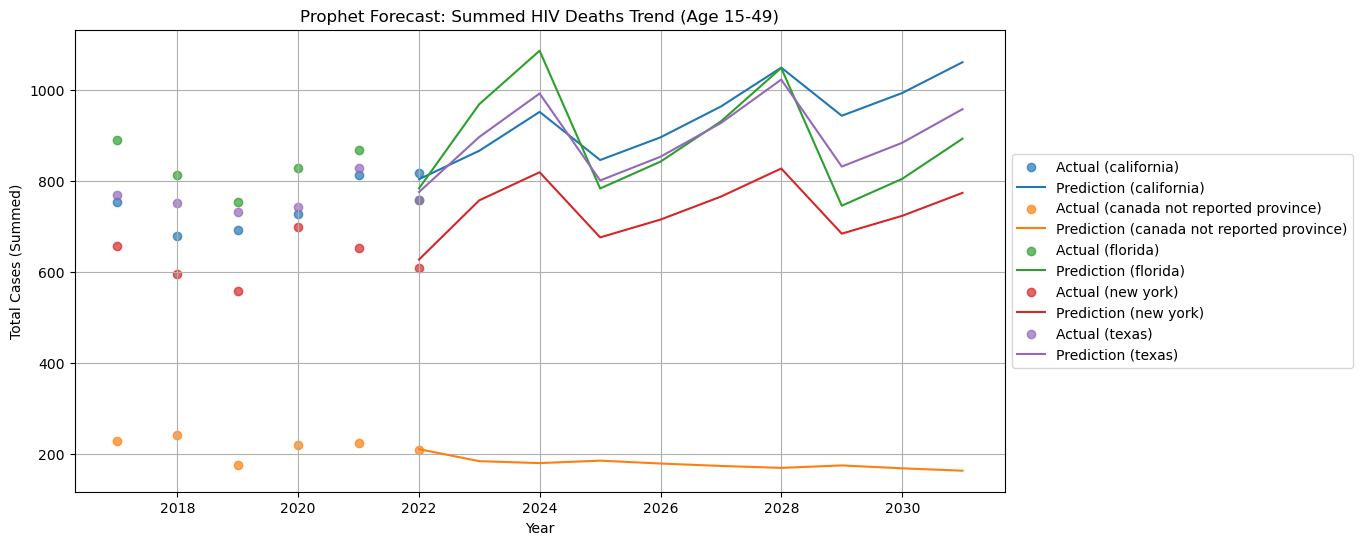

23:38:25 - cmdstanpy - INFO - Chain [1] start processing
23:38:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jabui\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
23:38:25 - cmdstanpy - INFO - Chain [1] start processing
23:38:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jabui\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jabui\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanp

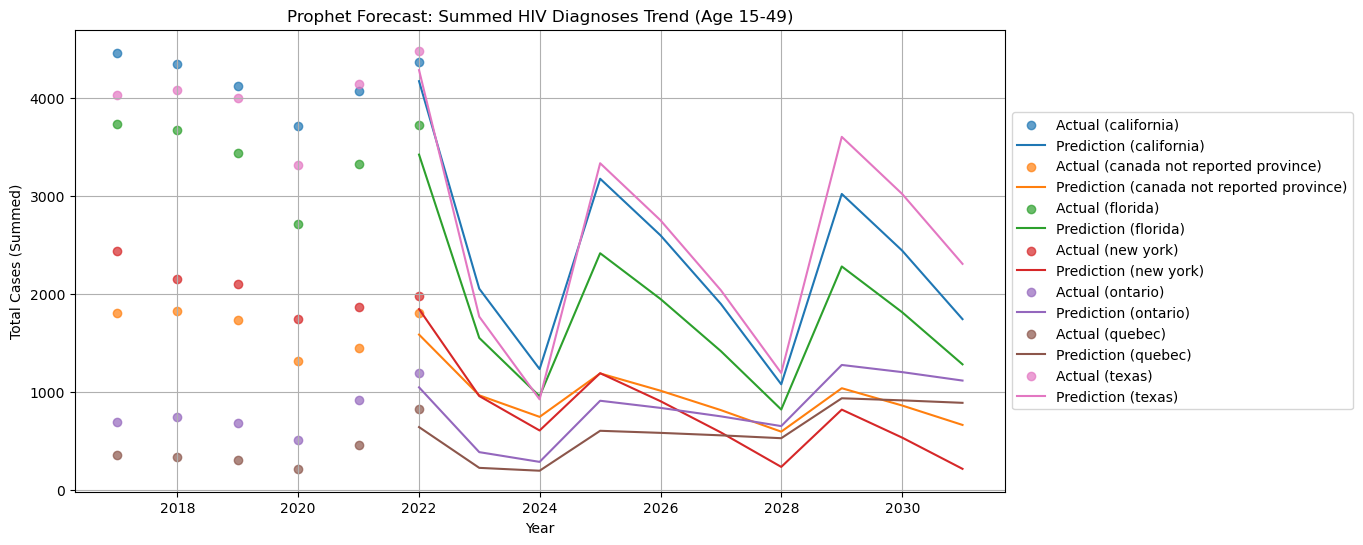

In [143]:

from prophet import Prophet

# Define selected geographies
selected_geographies = [
    "Ontario",
    "Quebec",
    "Florida",
    "New York",
    "California",
    "Texas",
    "Canada Not Reported Province"
]

# Convert 'Cases' column to numeric (handling spaces and missing values)
df_final['Cases'] = df_final['Cases'].astype(str).str.replace(" ", "", regex=True)
df_final['Cases'] = pd.to_numeric(df_final['Cases'], errors='coerce').fillna(0)

# Convert 'Indicator' and 'Geography' to lowercase for consistency
df_final['Indicator'] = df_final['Indicator'].str.lower()
df_final['Geography'] = df_final['Geography'].str.lower()

# Ensure 'Year' is an integer and remove invalid years
df_final['Year'] = pd.to_numeric(df_final['Year'], errors='coerce')
df_final = df_final[df_final['Year'] >= 2000]  # Keep only relevant years
# Aggregate the dataset by Year, Geography, and Indicator (sum of cases)
df_prophet_analysis = df_final[
    (df_final["Age Group"] == "15-49") & 
    (df_final["Geography"].isin([geo.lower() for geo in selected_geographies]))
].groupby(["Year", "Geography", "Indicator"])["Cases"].sum().reset_index()

# Function to apply Prophet model for forecasting using summed data
def apply_prophet_summed(df_grouped, indicator, title):
    plt.figure(figsize=(12, 6))

    # Extract unique geographies
    geographies = df_grouped['Geography'].unique()
    
    for geography in geographies:
        geo_data = df_grouped[
            (df_grouped['Geography'] == geography) & (df_grouped["Indicator"] == indicator)
        ][['Year', 'Cases']].sort_values(by='Year')

        if len(geo_data) > 2:  # Ensure enough data points for Prophet
            # Rename columns for Prophet compatibility
            geo_data = geo_data.rename(columns={'Year': 'ds', 'Cases': 'y'})

            # Convert Year to datetime format
            geo_data['ds'] = pd.to_datetime(geo_data['ds'], format='%Y')

            # Fit Prophet model
            model = Prophet()
            model.fit(geo_data)

            # Create future dataframe (predict for 2023-2028)
            last_year = geo_data['ds'].max()  # Get last available year
            future = model.make_future_dataframe(periods=9, freq='Y')

            # Convert last_year to datetime before filtering
            future = future[future['ds'] >= pd.to_datetime(last_year)]

            # Forecast and plot
            forecast = model.predict(future)

            # Plot actual data
            plt.scatter(geo_data['ds'], geo_data['y'], label=f'Actual ({geography})', alpha=0.7)

            # Plot Prophet forecast
            plt.plot(forecast['ds'], forecast['yhat'], linestyle='-', label=f'Prediction ({geography})')

    plt.xlabel('Year')
    plt.ylabel('Total Cases (Summed)')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

# Apply Prophet forecast for summed HIV Deaths
apply_prophet_summed(df_prophet_analysis, "hiv deaths", "Prophet Forecast: Summed HIV Deaths Trend (Age 15-49)")

# Apply Prophet forecast for summed HIV Diagnoses
apply_prophet_summed(df_prophet_analysis, "hiv diagnoses", "Prophet Forecast: Summed HIV Diagnoses Trend (Age 15-49)")



# Save original and cleaned datasets in a new Excel file
with pd.ExcelWriter('HIV_DATABASE_CLEANED.xlsx') as writer:
    df.to_excel(writer, sheet_name='Original Data', index=False)
    df_cleaned.to_excel(writer, sheet_name='Cleaned Data', index=False)
    df_tested.to_excel(writer, sheet_name='Tested Population', index=False)
    df_positive_percentage.to_excel(writer, sheet_name='Positive Percentage', index=False)
    

print("Cleaning completed. File saved as 'HIV_DATABASE_CLEANED.xlsx' with original and cleaned data.")
